This notebook introduces the fundamental objects of `MDAnalysis`:
 - the `Universe`,
 - `AtomGroup`, and `Atom` objects.
 - selecting and manipulating `AtomGroup`s
 - `Residue`s and `Segment`s
 - `Bond` `Angle` and `Dihedral`

# 1. Fundamental objects

## `Universes` and `AtomGroups`

> "If you wish to make an apple pie from scratch, you must first invent the Universe." 

> ~ Carl Sagan

First, we need to import `MDAnalysis`, giving us access to all the components in its namespace:

In [2]:
import MDAnalysis as mda
import MDAnalysisData as data
print(mda.__version__)
print(data.__version__)

0.19.1-dev
0.3.0+6.g7d231ce


One of the fundamental objects in the `MDAnalysis` data model is the `Universe` object.
A `Universe` can be thought of as an interface to all the raw details of a simulation.
It contains all of a simulations' topology information (names, charges, masses etc) at the least,
but usually also includes trajectory information as well.

In order to do anything, we do need some actual molecular dynamics data to work with.
You should have downloaded a dataset package for this workshop;
Let's load a dataset.

In [3]:
adk_dataset = data.datasets.fetch_adk_equilibrium()
print(adk_dataset['DESCR'])

.. -*- coding: utf-8 -*-

.. _`adk-equilibrium-dataset`:

AdK equilibrium trajectory dataset

MD trajectory of apo adenylate kinase with CHARMM27 force field and
simulated with explicit water and ions in NPT at 300 K and 1
bar. Saved every 240 ps for a total of 1.004 µs. Produced on PSC
Anton. The trajectory only contains the protein while all solvent was
stripped in order to reduce the trajectory size. The whole protein was
superimposed on the CORE domain of AdK by RMSD fitting.

The topology is contained in the PSF file (CHARMM format). The
trajectory is contained in the DCD file (CHARMM/NAMD format).


Notes
-----

Data set characteristics:

 :size: 161 MB
 :number of trajectories: 1
 :number of frames:  4187
 :number of particles: 3341
 :creator: Sean Seyler
 :URL:  `10.6084/m9.figshare.5108170.v1 <https://doi.org/10.6084/m9.figshare.5108170.v1>`_
 :license: `CC-BY 4.0 <https://creativecommons.org/licenses/by/4.0/legalcode>`_
 :reference: [Seyler2017]_
    

.. [Seyler2017]  Seyler

To make a Universe, we need at the very least a topology file. We'll use one for a simulation system that includes adenylate kinase with the water removed:

In [24]:
u = mda.Universe(adk_dataset['topology'], adk_dataset['trajectory'])

print(u)

<Universe with 3341 atoms>


We now have a `Universe` object. Since the topology (PSF) file we loaded contained both atom identities and bond information, the `Universe` is able to access these details.

We can access all atoms in the `Universe` through the `Universe.atoms` attribute.
This returns an `AtomGroup` which is probably the most important class we will learn about.

In [5]:
ag = u.atoms
type(ag)

MDAnalysis.core.groups.AtomGroup

We previously learnt about `numpy` arrays, which represent a series of numbers.

An `AtomGroup` is like an array of atoms, and offers access to the data of these atoms:

In [6]:
ag.indices

array([   0,    1,    2, ..., 3338, 3339, 3340])

In [7]:
ag.names

array(['N', 'HT1', 'HT2', ..., 'CA', 'HA1', 'HA2'], dtype=object)

In [8]:
ag.resnames

array(['MET', 'MET', 'MET', ..., 'GLY', 'GLY', 'GLY'], dtype=object)

In [9]:
ag.resids

array([  1,   1,   1, ..., 214, 214, 214])

In [10]:
ag.charges

array([-0.30000001,  0.33000001,  0.33000001, ..., -0.02      ,
        0.09      ,  0.09      ])

In [11]:
ag.masses

array([14.007,  1.008,  1.008, ..., 12.011,  1.008,  1.008])

In [12]:
ag.types

array(['NH3', 'HC', 'HC', ..., 'CT2', 'HB', 'HB'], dtype=object)

All of these attributes of an `AtomGroup` return numpy arrays of the same length as the `AtomGroup` itself;
that is, each element corresponds to each atom in the `AtomGroup`, in order.

## Working with individual atoms

We can also work with individual atoms, though in practice this is rare, and in the future will be relatively inefficient when operating on multiple atoms compared to operating on a whole `AtomGroup`. At the moment, however, these operations are comparable in speed.

In [13]:
a = u.atoms[0]
print(a)

<Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>


In [14]:
print("name:", a.name)
print("resid:", a.resid)
print("resname:", a.resname)

name: N
resid: 1
resname: MET


# Selecting atoms

It is also rare that we want to operate on all atoms in the system!
MDAnalysis offers a few ways to select atoms,
in this sectio we will go over the most useful methods.

## Numpy style selections

As previously mentioned, an `AtomGroup` is like an array of atoms,
and therefore we can slice it exactly like we would slice a `numpy` array

### Fancy indexing

The simplest option to select specific atom is to use fancy indexing. You can specify the atoms in a list

In [15]:
u.atoms[[1, 4, 5 , 0]]

<AtomGroup with 4 atoms>

or as a range

In [16]:
u.atoms[1:10]

<AtomGroup with 9 atoms>

### Boolean indexing

You can also create an array with True/False values of the same length as the atomgroup. Every atom for which the array is set to True will be selected.

In [17]:
selection_ar = u.atoms.resnames == 'GLY'
print("selection array = ", selection_ar)
u.atoms[selection_ar]

selection array =  [False False False ...  True  True  True]


<AtomGroup with 141 atoms>

or shorter

In [18]:
u.atoms[u.atoms.resnames == 'GLY']

<AtomGroup with 141 atoms>

## Selection Strings

We've already seen that complex selections can be performed on `AtomGroups` using numpy style indexing.
However, `MDAnalysis` also features a CHARMM-style atom selection mechanism that is often more convenient.

In [ ]:
u.atoms.select_atoms?

Although boolean selections work well enough for selecting out atoms from AtomGroups, the selection language makes more complex selections possible with probably less effort. For example, we can selections of the 

In [20]:
acidic = u.select_atoms("(resname GLU or resname ASP)")
acidic

<AtomGroup with 474 atoms>

In [21]:
acidic_o = acidic.select_atoms('(name OD* or name OE*)')
acidic_o

<AtomGroup with 70 atoms>

As a shortcut, multiple values can be given and these will be implicitly OR'd together.
For example to select all atoms with name NZ OR NH* in residues named LYS or ARG:

In [22]:
basic_n = u.select_atoms( "(resname LYS ARG) and (name NZ NH*)")
basic_n

<AtomGroup with 44 atoms>

### Geometric selections

The `select_atoms` method also has various geometric keywords that make selecting atoms based on geometric criteria much easier.

If we want only residues that are involved in salt bridges, we can use our `AtomGroups` as part of additional selections. We can also use the `around` selection operator to specify only atoms within 4 angstroms. At the end we can get the full residues back.

In [29]:
acidic = u.select_atoms("group acidic and around 4 group basic", acidic=acidic_o, basic=basic_n)
basic = u.select_atoms("group basic and around 4 group acidic", acidic=acidic_o, basic=basic_n)

In [31]:
acidic

<AtomGroup with 20 atoms>

## Set operations

`AtomGroup`s can also be combined using `&` for and and `|` for or

In [32]:
u.atoms[(u.atoms.masses < 10) & (u.atoms.resnames == 'ARG')]

<AtomGroup with 169 atoms>

remember to surround expressions of `ag.attr op value` in braces. Not doing so will result in a TypeError.

In [33]:
u.atoms[u.atoms.masses < 10 & u.atoms.resnames == 'ARG']

TypeError: unsupported operand type(s) for &: 'int' and 'str'

By design, an `AtomGroup` can have repeats of the same atom, for example through this selection:

In [36]:
ag = u.atoms[[0, 0, 1, 2, 4, 4, 5]]
ag

<AtomGroup with 7 atoms>

The `unique` property will return a version of the `AtomGroup` with only one of each Atom:

In [35]:
ag.unique

<AtomGroup with 5 atoms>

### Challenge: count the number of glycine residues in the protein

In [21]:
import numpy as np

In [22]:
r = u.atoms[u.atoms.resnames == 'GLY'].resids

In [23]:
len(np.unique(r))

20

## `ResidueGroups` and `SegmentGroups`

The `Universe` also gives higher-order topology objects, including `ResidueGroups` and `SegmentGroups`. We can access all residues in the `Universe` with:

In [24]:
u.residues

<ResidueGroup with 214 residues>

And all segments with:

In [25]:
u.segments

<SegmentGroup with 1 segment>

`ResidueGroups` and `SegmentGroups` also behave similarly to `AtomGroups`, with many of their methods returning `numpy` arrays with each element corresponding to a single residue or segment, respectively.

In [26]:
u.residues.resnames

array(['MET', 'ARG', 'ILE', 'ILE', 'LEU', 'LEU', 'GLY', 'ALA', 'PRO',
       'GLY', 'ALA', 'GLY', 'LYS', 'GLY', 'THR', 'GLN', 'ALA', 'GLN',
       'PHE', 'ILE', 'MET', 'GLU', 'LYS', 'TYR', 'GLY', 'ILE', 'PRO',
       'GLN', 'ILE', 'SER', 'THR', 'GLY', 'ASP', 'MET', 'LEU', 'ARG',
       'ALA', 'ALA', 'VAL', 'LYS', 'SER', 'GLY', 'SER', 'GLU', 'LEU',
       'GLY', 'LYS', 'GLN', 'ALA', 'LYS', 'ASP', 'ILE', 'MET', 'ASP',
       'ALA', 'GLY', 'LYS', 'LEU', 'VAL', 'THR', 'ASP', 'GLU', 'LEU',
       'VAL', 'ILE', 'ALA', 'LEU', 'VAL', 'LYS', 'GLU', 'ARG', 'ILE',
       'ALA', 'GLN', 'GLU', 'ASP', 'CYS', 'ARG', 'ASN', 'GLY', 'PHE',
       'LEU', 'LEU', 'ASP', 'GLY', 'PHE', 'PRO', 'ARG', 'THR', 'ILE',
       'PRO', 'GLN', 'ALA', 'ASP', 'ALA', 'MET', 'LYS', 'GLU', 'ALA',
       'GLY', 'ILE', 'ASN', 'VAL', 'ASP', 'TYR', 'VAL', 'LEU', 'GLU',
       'PHE', 'ASP', 'VAL', 'PRO', 'ASP', 'GLU', 'LEU', 'ILE', 'VAL',
       'ASP', 'ARG', 'ILE', 'VAL', 'GLY', 'ARG', 'ARG', 'VAL', 'HSE',
       'ALA', 'PRO',

In [27]:
u.segments.segids

array(['ADK'], dtype=object)

We can more easily get the number of glycine residues using a `ResidueGroup`.

In [28]:
u.atoms[u.atoms.resnames == 'GLY'].residues.n_residues

20

or perhaps more Pythonic:

In [29]:
len(u.atoms[u.atoms.resnames == 'GLY'].residues)

20

## Using coordinates

`AtomGroups` are more interesting with coordinate data attached to them. Our topology file has none of this, so using

In [30]:
u.atoms.positions

AttributeError: AtomGroup has no attribute positions

yields an `AttributeError`. Let's load some coordinates by creating a new Universe, but with a topology + a trajectory.

In [31]:
u = mda.Universe(adk_dataset['topology'], adk_dataset['trajectory'])

Now this will work.

In [32]:
u.atoms.positions

array([[ 2.8706636, 10.604456 ,  9.750288 ],
       [ 3.109205 , 11.324709 ,  9.038997 ],
       [ 3.7460954, 10.243008 , 10.179911 ],
       ...,
       [-7.499353 , 10.892199 , 12.3347645],
       [-6.5965843, 10.8342705, 12.924728 ],
       [-8.348269 , 10.599268 , 12.934707 ]], dtype=float32)

### Challenge: calculate the center of geometry of the C$_\alpha$ atoms

In [33]:
u.atoms[u.atoms.names == 'CA'].positions.mean(axis=0)

array([ 1.0424447,  2.2344341, -5.152382 ], dtype=float32)

Alternatively, we have a builtin for this:

In [34]:
u.atoms[u.atoms.names == 'CA'].centroid()

array([ 1.0424447,  2.2344341, -5.152382 ], dtype=float32)

## Bonds, angles, and dihedrals

We can also get at connectivity information between atoms, such as bonds, angles, and dihedrals.

In [35]:
u.bonds

<TopologyGroup containing 3365 bonds>

In [36]:
u.angles

<TopologyGroup containing 6123 angles>

In [37]:
u.dihedrals

<TopologyGroup containing 8921 dihedrals>

In [38]:
u.bonds[3]

<Bond between: Atom 0, Atom 4>

Want the actual value?

In [39]:
u.bonds[3].value()

1.4905602

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  23.,  295.,   57.,  287., 1022.,    0.,    0.,   31.,  105.,
         126.,   41.,   71.,  114.,   88.,   81.,  101.,  129.,  186.,
         255.,  221.,  102.,   15.,    2.,    0.,    0.,    0.,    4.,
           2.,    3.,    4.]),
 array([0.95999745, 0.99054587, 1.02109429, 1.05164271, 1.08219113,
        1.11273955, 1.14328797, 1.17383639, 1.20438481, 1.23493323,
        1.26548165, 1.29603007, 1.32657849, 1.35712691, 1.38767533,
        1.41822375, 1.44877217, 1.47932059, 1.50986901, 1.54041743,
        1.57096585, 1.60151427, 1.63206269, 1.66261111, 1.69315953,
        1.72370795, 1.75425637, 1.78480479, 1.81535321, 1.84590163,
        1.87645005]),
 <a list of 30 Patch objects>)

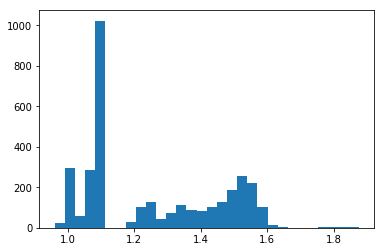

In [41]:
plt.hist(u.bonds.values(), bins=30)

These work the same way as `AtomGroup`s. They're sliceable, and indexing them works too to give individual bonds, angles, dihedrals.

## Special Functions

The `split` function can be used to return a list of atomgroups that are separated by the specified level. For example `u.atoms.split('residue')` will return a list of all residues as atomgroups.

In [55]:
u.atoms.split('residue')

[<AtomGroup with 19 atoms>,
 <AtomGroup with 24 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 7 atoms>,
 <AtomGroup with 10 atoms>,
 <AtomGroup with 14 atoms>,
 <AtomGroup with 7 atoms>,
 <AtomGroup with 10 atoms>,
 <AtomGroup with 7 atoms>,
 <AtomGroup with 22 atoms>,
 <AtomGroup with 7 atoms>,
 <AtomGroup with 14 atoms>,
 <AtomGroup with 17 atoms>,
 <AtomGroup with 10 atoms>,
 <AtomGroup with 17 atoms>,
 <AtomGroup with 20 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 17 atoms>,
 <AtomGroup with 15 atoms>,
 <AtomGroup with 22 atoms>,
 <AtomGroup with 21 atoms>,
 <AtomGroup with 7 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 14 atoms>,
 <AtomGroup with 17 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 11 atoms>,
 <AtomGroup with 14 atoms>,
 <AtomGroup with 7 atoms>,
 <AtomGroup with 12 atoms>,
 <AtomGroup with 17 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 24 atoms>

Another method is `groupby`. You use it to select for a topolgy attribute (*resnames*, *names*, *masses*, ...). `groupby` will return a dictionary where the keys are all unique values of a given topology attribute and the values are a group of atoms that have this value.

In [57]:
u.atoms.groupby('resnames')

{'ARG': <AtomGroup with 312 atoms>,
 'GLU': <AtomGroup with 270 atoms>,
 'VAL': <AtomGroup with 304 atoms>,
 'ALA': <AtomGroup with 190 atoms>,
 'SER': <AtomGroup with 55 atoms>,
 'PHE': <AtomGroup with 100 atoms>,
 'LYS': <AtomGroup with 396 atoms>,
 'GLN': <AtomGroup with 136 atoms>,
 'TYR': <AtomGroup with 147 atoms>,
 'PRO': <AtomGroup with 140 atoms>,
 'THR': <AtomGroup with 154 atoms>,
 'CYS': <AtomGroup with 11 atoms>,
 'GLY': <AtomGroup with 141 atoms>,
 'ASP': <AtomGroup with 204 atoms>,
 'ASN': <AtomGroup with 56 atoms>,
 'HSE': <AtomGroup with 51 atoms>,
 'MET': <AtomGroup with 104 atoms>,
 'LEU': <AtomGroup with 304 atoms>,
 'ILE': <AtomGroup with 266 atoms>}

Multiple topology attributes can also be given.

In [61]:
u.atoms.groupby(['resnames', 'names'])

{('ARG', 'O'): <AtomGroup with 13 atoms>,
 ('ARG', 'HN'): <AtomGroup with 13 atoms>,
 ('ARG', 'HG1'): <AtomGroup with 13 atoms>,
 ('ARG', 'CA'): <AtomGroup with 13 atoms>,
 ('ARG', 'HB1'): <AtomGroup with 13 atoms>,
 ('ARG', 'HG2'): <AtomGroup with 13 atoms>,
 ('ARG', 'HD2'): <AtomGroup with 13 atoms>,
 ('ARG', 'C'): <AtomGroup with 13 atoms>,
 ('ARG', 'HH12'): <AtomGroup with 13 atoms>,
 ('ARG', 'CG'): <AtomGroup with 13 atoms>,
 ('ARG', 'N'): <AtomGroup with 13 atoms>,
 ('ARG', 'HA'): <AtomGroup with 13 atoms>,
 ('ARG', 'NH2'): <AtomGroup with 13 atoms>,
 ('ARG', 'NH1'): <AtomGroup with 13 atoms>,
 ('ARG', 'HD1'): <AtomGroup with 13 atoms>,
 ('ARG', 'HE'): <AtomGroup with 13 atoms>,
 ('ARG', 'CZ'): <AtomGroup with 13 atoms>,
 ('ARG', 'HH21'): <AtomGroup with 13 atoms>,
 ('ARG', 'HH11'): <AtomGroup with 13 atoms>,
 ('ARG', 'HH22'): <AtomGroup with 13 atoms>,
 ('ARG', 'NE'): <AtomGroup with 13 atoms>,
 ('ARG', 'CB'): <AtomGroup with 13 atoms>,
 ('ARG', 'HB2'): <AtomGroup with 13 atoms>

### Example: domain movement of adenylate kinase (AdK)

AdK has three domains: CORE, NMP, LID. The NMP and LID move relative to the CORE. Movements can be defined by two angles between the two domains, $\theta_{\text{NMP}}$ and $\theta_{\text{LID}}$.

These angles are defined as:
* CORE residues 1-29, 60-121, 160-214 (gray)
* NMP residues 30-59 (blue)
* LID residues 122-159 (yellow)

In [ ]:
from IPython.core.display import Image

Image("MDAnalysisTutorial/doc/sphinx/figs/angle_defs.png")

AdK undergoes a conformational transition during which the NMP and LID domain move relative to the CORE domain. The transition can be characterized by the angles between the domains:

In [ ]:
Image("MDAnalysisTutorial/doc/sphinx/figs/6b_angle_def_open.png", width=500)

For simplicity, define $\theta_{\text{NMP}}$ and $\theta_{\text{LID}}$ between the centers of mass of *backbone* atoms of groups of the following atoms `A`, `B`, `C`:

Definition of $\theta_{\text{NMP}}$

A: 115-125, B: 90-100, C: 35-55

Definition of $\theta_{\text{LID}}$

A: 179-185, B: 115-125, C: 125-153

The angle between vectors $\vec{BA}$ and $\vec{BC}$ is \begin{equation*} \theta = \arccos\left(\frac{\vec{BA}\cdot\vec{BC}}{|\vec{BA}||\vec{BC}|}\right) \end{equation*}

With `numpy`:
```python
np.arccos(np.cdot(BA, BC))/(np.linalg.norm(BA) * np.linalg.norm(BC))
```


Write two functions `theta_NMP()` and `theta_LID()` that calculate these angles, given the universe.

Hint:

In [ ]:
A = u.select_atoms("resid 115:125 and backbone").center_of_geometry()

In [ ]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(u):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 115:125 and backbone").center_of_geometry()
    B = u.select_atoms("resid 90:100 and backbone").center_of_geometry()
    A = u.select_atoms("resid 35:55 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(u):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 179:185 and backbone").center_of_geometry()
    B = u.select_atoms("resid 115:125 and backbone").center_of_geometry()
    A = u.select_atoms("resid 125:153 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

And now Oliver.